In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [3]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [23]:
import numpy as np
import pandas as pd
from copy import copy

class kde_approximator_1D:
    
    def __init__(self, kernel='gaus', bandwidth=1.):
        """
        KDE allows us a method of drawing samples from an
        already known set of data, with the same distribution
        of data. This is done by assuming a probability dist
        for each point and using that as a probabilistic 
        interpretation of the data.
        ---
        KWargs:
        kernel: type of probability dist to assume. Options
        "gaus", "uniform". (string)
        bandwidth: Used with gaussian, sets the width of the 
        assumed gaussian distribution. (float)
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        if kernel == "gaus":
            self.estim = self.gaus
        elif kernel == "uniform":
            self.estim = self.uniform
        else:
            raise TypeError("Invalid Kernel Selection")
        self.data_cols = None
        
    def gaus(self, x, mu):
        """
        Returns the probability of x given the mean and standard
        deviation provided - assuming a Gaussian probability.
        ---
        Inputs: x (the value to find the probability for, float),
        mu (the mean value of the feature in the training data, float),
        sig (the standard deviation of the feature in the training data, float)
        Outputs: probability (float)
        """
        sig=self.bandwidth
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-(x-mu)**2/(2*sig**2))
    
    def uniform(self, x, pt):
        """
        Returns probability of x, assuming uniform distribution
        in each direction around pt2 in range (-1, 1).
        """
        diff = np.abs(x - pt)
        probs = np.zeros_like(diff)
        probs[diff <= 1] = 0.5
        return probs
        
    def fit(self, X):
        """
        Copies the data for later use.
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        self.data_cols = X.shape[1]
        self.X = copy(X)
    
    def make_surface(self):
         """
        Using a sampling grid, goes point by point along the
        grid to determine the probability of data existing
        at that point, given all of the known data.
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.X
        probs = []
        for col in range(self.data_cols): 
            data = X.T[col]
            rangemin = np.min(data)-abs(np.min(data)*0.10)
            rangemax = np.max(data)+abs(np.max(data)*0.10)
            span = np.linspace(rangemin, rangemax, 200)
            for p in span:
                prob = 0.
                for d in data:
                    prob += self.estim(p,d)
                probs.append(prob)
        self.region = span 
        self.probs = probs
    
    def sample(self, num_samples=1, random_state=None):
        """
        Given the data we trained on, sample new points
        based on the density of the data. Use the kernel
        to sample not just the available points, but the 
        whole region of possiblities given the kernel.
        ---
        Inputs: 
        num_samples: how many samples to draw (int)
        random_state: seed to make the random draws 
        reproducible (int)
        """
        if random_state:
            np.random.seed(random_state)
        
        samples = []
        for i in range(num_samples):
            pt = self.X[np.random.randint(self.X.shape[0])]
            sample_pt = []
            for dim in pt:
                if self.kernel == "gaus":
                    sample_pt.append(np.random.normal(dim, self.bandwidth))
                elif self.kernel == "uniform":
                    sample_pt.append(np.random.uniform(dim-1,dim+1))
            samples.append(sample_pt)
        return np.array(samples)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

In [24]:
X = np.hstack((np.random.normal(0,0.5,100), np.random.normal(5,1,100), np.random.normal(-5,2,50)))
X.shape

(250,)

In [25]:
kde = kde_approximator_1D(kernel='uniform', bandwidth=1)
kde.fit(X)
kde.make_surface()

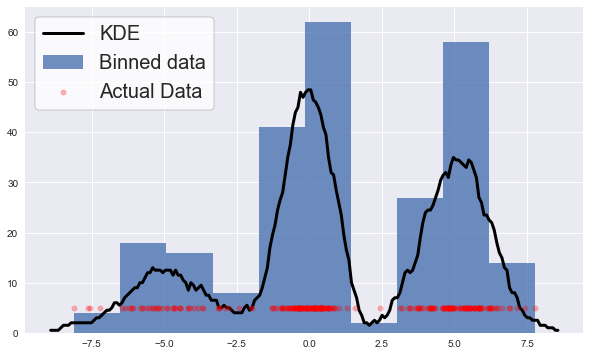

In [26]:
plt.figure(figsize=(10,6))

plt.hist(X, label="Binned data", alpha=0.8, zorder=1)
plt.plot(kde.region, kde.probs, c='k', lw=3, label="KDE", zorder=2);
plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
plt.legend(fontsize=20, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');

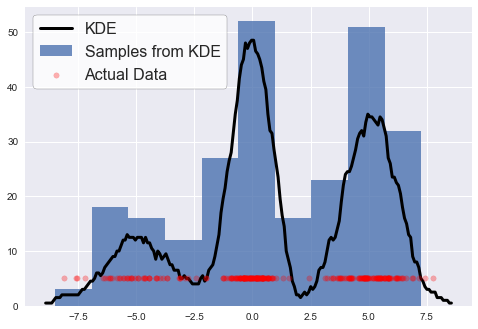

In [27]:
samp = kde.sample(num_samples=250, random_state=42)
plt.figure()
plt.hist(samp, label="Samples from KDE", alpha=0.8, zorder=1)
plt.plot(kde.region, kde.probs, c='k', lw=3, label="KDE", zorder=2);
plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
plt.legend(fontsize=16, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');

In [29]:
kde = kde_approximator_1D(kernel='gaus', bandwidth=1)
kde.fit(X)
kde.make_surface()

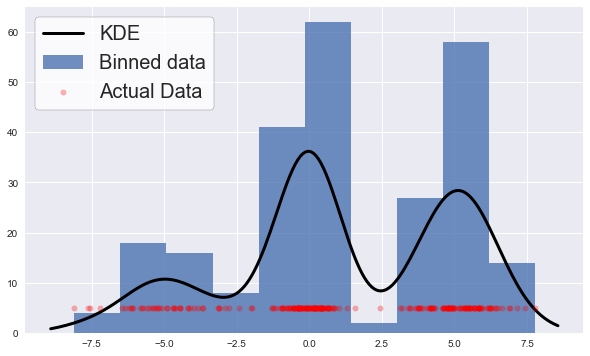

In [30]:
plt.figure(figsize=(10,6))

plt.hist(X, label="Binned data", alpha=0.8, zorder=1)
plt.plot(kde.region, kde.probs, c='k', lw=3, label="KDE", zorder=2);
plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
plt.legend(fontsize=20, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');

# What about in higher dimensions than 1?

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import copy
plt.style.use('seaborn')

class kde_approximator:
    
    def __init__(self, kernel='gaus', bandwidth=1., grid_fineness=10.):
        """
        KDE allows us a method of drawing samples from an
        already known set of data, with the same distribution
        of data. This is done by assuming a probability dist
        for each point and using that as a probabilistic 
        interpretation of the data.
        ---
        KWargs:
        kernel: type of probability dist to assume. Options
        "gaus", "uniform". (string)
        bandwidth: Used with gaussian, sets the width of the 
        assumed gaussian distribution. (float)
        grid_fineness: Sets how many points to use in each
        dimension when building a probability surface for 
        plotting purposes.
        
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        if kernel == "gaus":
            self.estim = self.gaus
        elif kernel == "uniform":
            self.estim = self.uniform
        else:
            raise TypeError("Invalid Kernel Selection")
        self.grid_fineness = grid_fineness
        self.data_cols = None
        
    def gaus(self, x, mu):
        """
        Returns the probability of x given the mean and standard
        deviation provided - assuming a Gaussian probability.
        ---
        Inputs: x (the value to find the probability for, float),
        mu (the mean value of the feature in the training data, float),
        sig (the standard deviation of the feature in the training data, float)
        Outputs: probability (float)
        """
        sig = self.bandwidth
        diff = np.sqrt(np.sum((x-mu)**2))
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff**2/(2*sig**2))
    
    def uniform(self, x, pt):
        """
        Returns probability of x, assuming uniform distribution
        in each direction around pt2 in range (-1, 1).
        """
        diff = np.sqrt(np.sum((x-pt)**2))
        probs = np.zeros_like(diff)
        probs[diff <= 1] = 0.5
        return probs
    
    def get_grid(self, X):
        """
        Given a dataset, figure out how many dimensions there are
        then create a series of sampling points based on the
        user's requested grid_fineness. Create this sampling region
        over the span of the data +/- 10% in each dimension.
        ---
        Input: X, Data matrix
        """
        mins, maxes = [], []
        
        for col in range(self.data_cols): 
            data = X.T[col]
            mins.append(np.min(data)-abs(np.min(data)*0.10))
            maxes.append(np.max(data)+abs(np.max(data)*0.10))
        grid = np.stack(np.meshgrid(*[np.linspace(i,j,self.grid_fineness) for i,j in zip(mins, maxes)], indexing='ij'),self.data_cols)
        return grid
    
    def fit(self, X):
        """
        Copies the data for later use.
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        self.data_cols = X.shape[1]
        self.X = copy(X)
    
    def make_surface(self):
        """
        Using a sampling grid, goes point by point along the
        grid to determine the probability of data existing
        at that point, given all of the known data.
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.X
        span = self.get_grid(X)
        
        probs = []
        points = []
        for dim in span:
            for p in dim:
                prob = 0.
                for d in X: 
                    prob += self.estim(p,d)
                if np.isnan(prob):
                    prob = 0.
                points.append(p)
                probs.append(prob)
        self.region = points 
        self.probs = probs
        
    def sample(self, num_samples=1, random_state=None):
        """
        Given the data we trained on, sample new points
        based on the density of the data. Use the kernel
        to sample not just the available points, but the 
        whole region of possiblities given the kernel.
        ---
        Inputs: 
        num_samples: how many samples to draw (int)
        random_state: seed to make the random draws 
        reproducible (int)
        """
        if random_state:
            np.random.seed(random_state)
        
        samples = []
        for i in range(num_samples):
            pt = self.X[np.random.randint(self.X.shape[0])]
            sample_pt = []
            for dim in pt:
                if self.kernel == "gaus":
                    sample_pt.append(np.random.normal(dim, self.bandwidth))
                elif self.kernel == "uniform":
                    sample_pt.append(np.random.uniform(dim-1,dim+1))
            samples.append(sample_pt)
        return np.array(samples)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def make_plot(self):
        """
        Creates a plot of the surface created by make_surface
        using 2D or 1D, depending on request.
        """
        if self.data_cols == 2:
            Xpl, Ypl  = zip(*self.region)
            Zpl = kde2.probs/max(self.probs)
            fig = plt.figure(dpi=200, figsize=(18,14))
            ax = fig.gca(projection='3d')
            ax.plot_trisurf(Xpl,Ypl,Zpl, cmap=plt.cm.rainbow, linewidth=1)

            Xsc, Ysc = zip(*X)
            ax.scatter(Xsc,Ysc,[max(Zpl)]*len(Xsc),c='k',s=20, label="Data", alpha=0.5);
            proxy = plt.Circle((0,0), fc="k")
            ax.legend([proxy],['Data (z = 1)'], fontsize=18, loc='upper right', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
            ax.set_zlabel("Norm. Prob.",fontsize=16, labelpad=10)
            ax.set_xlabel("X",fontsize=16, labelpad=10)
            ax.set_ylabel("Y",fontsize=16, labelpad=10);
        
        elif self.data_cols == 1:
            plt.figure(figsize=(10,6))
            plt.hist(X, label="Binned data", bins=18, alpha=0.8, zorder=1)
            plt.plot(self.region, self.probs, c='k', lw=3, label="KDE", zorder=2);
            plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
            plt.legend(fontsize=20, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
            ax = plt.gca()
        else:
            print("Can only draw if KDE is done on 2 or fewer columns.")
            return None
        return ax
        
    

In [36]:
X = np.vstack((np.random.normal(0,0.5,(100,2)), np.random.normal(5,1,(100,2)), np.random.normal(-5,1.5,(300,2))))
X.shape

(500, 2)

In [37]:
kde2 = kde_approximator(grid_fineness=60, bandwidth=1)
kde2.fit(X)
kde2.make_surface()

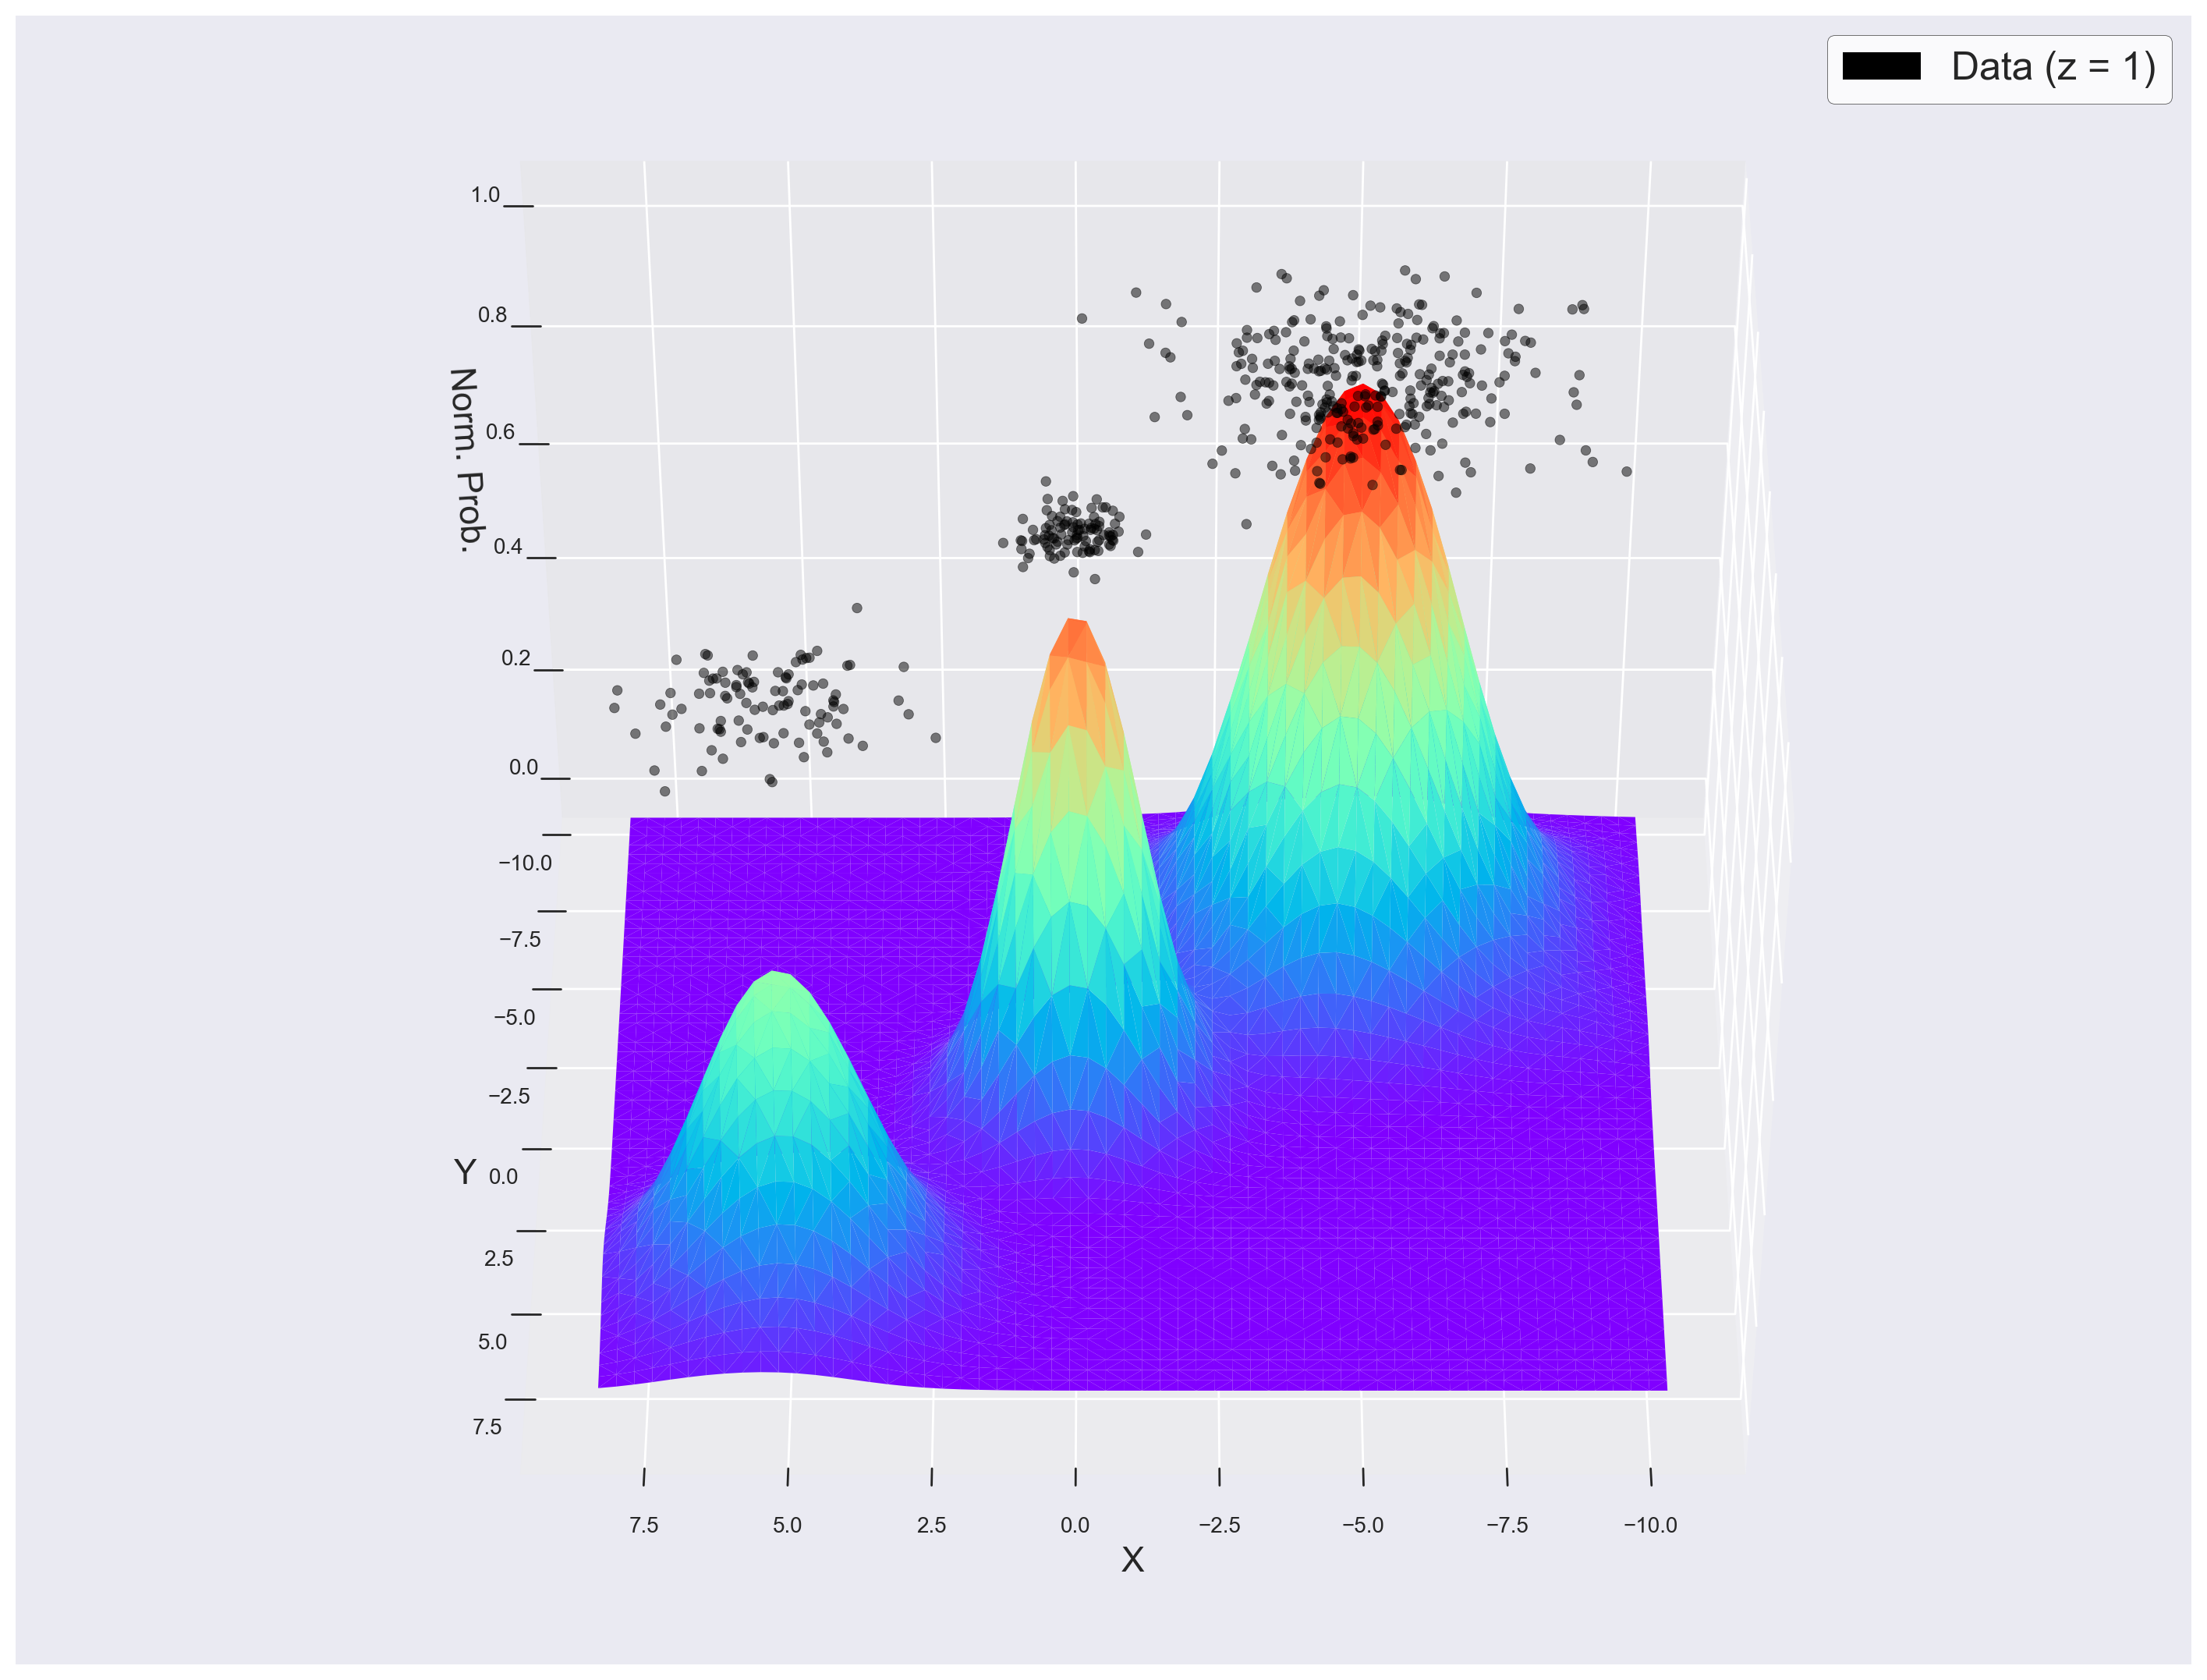

In [38]:
ax = kde2.make_plot()
ax.view_init(45,90);

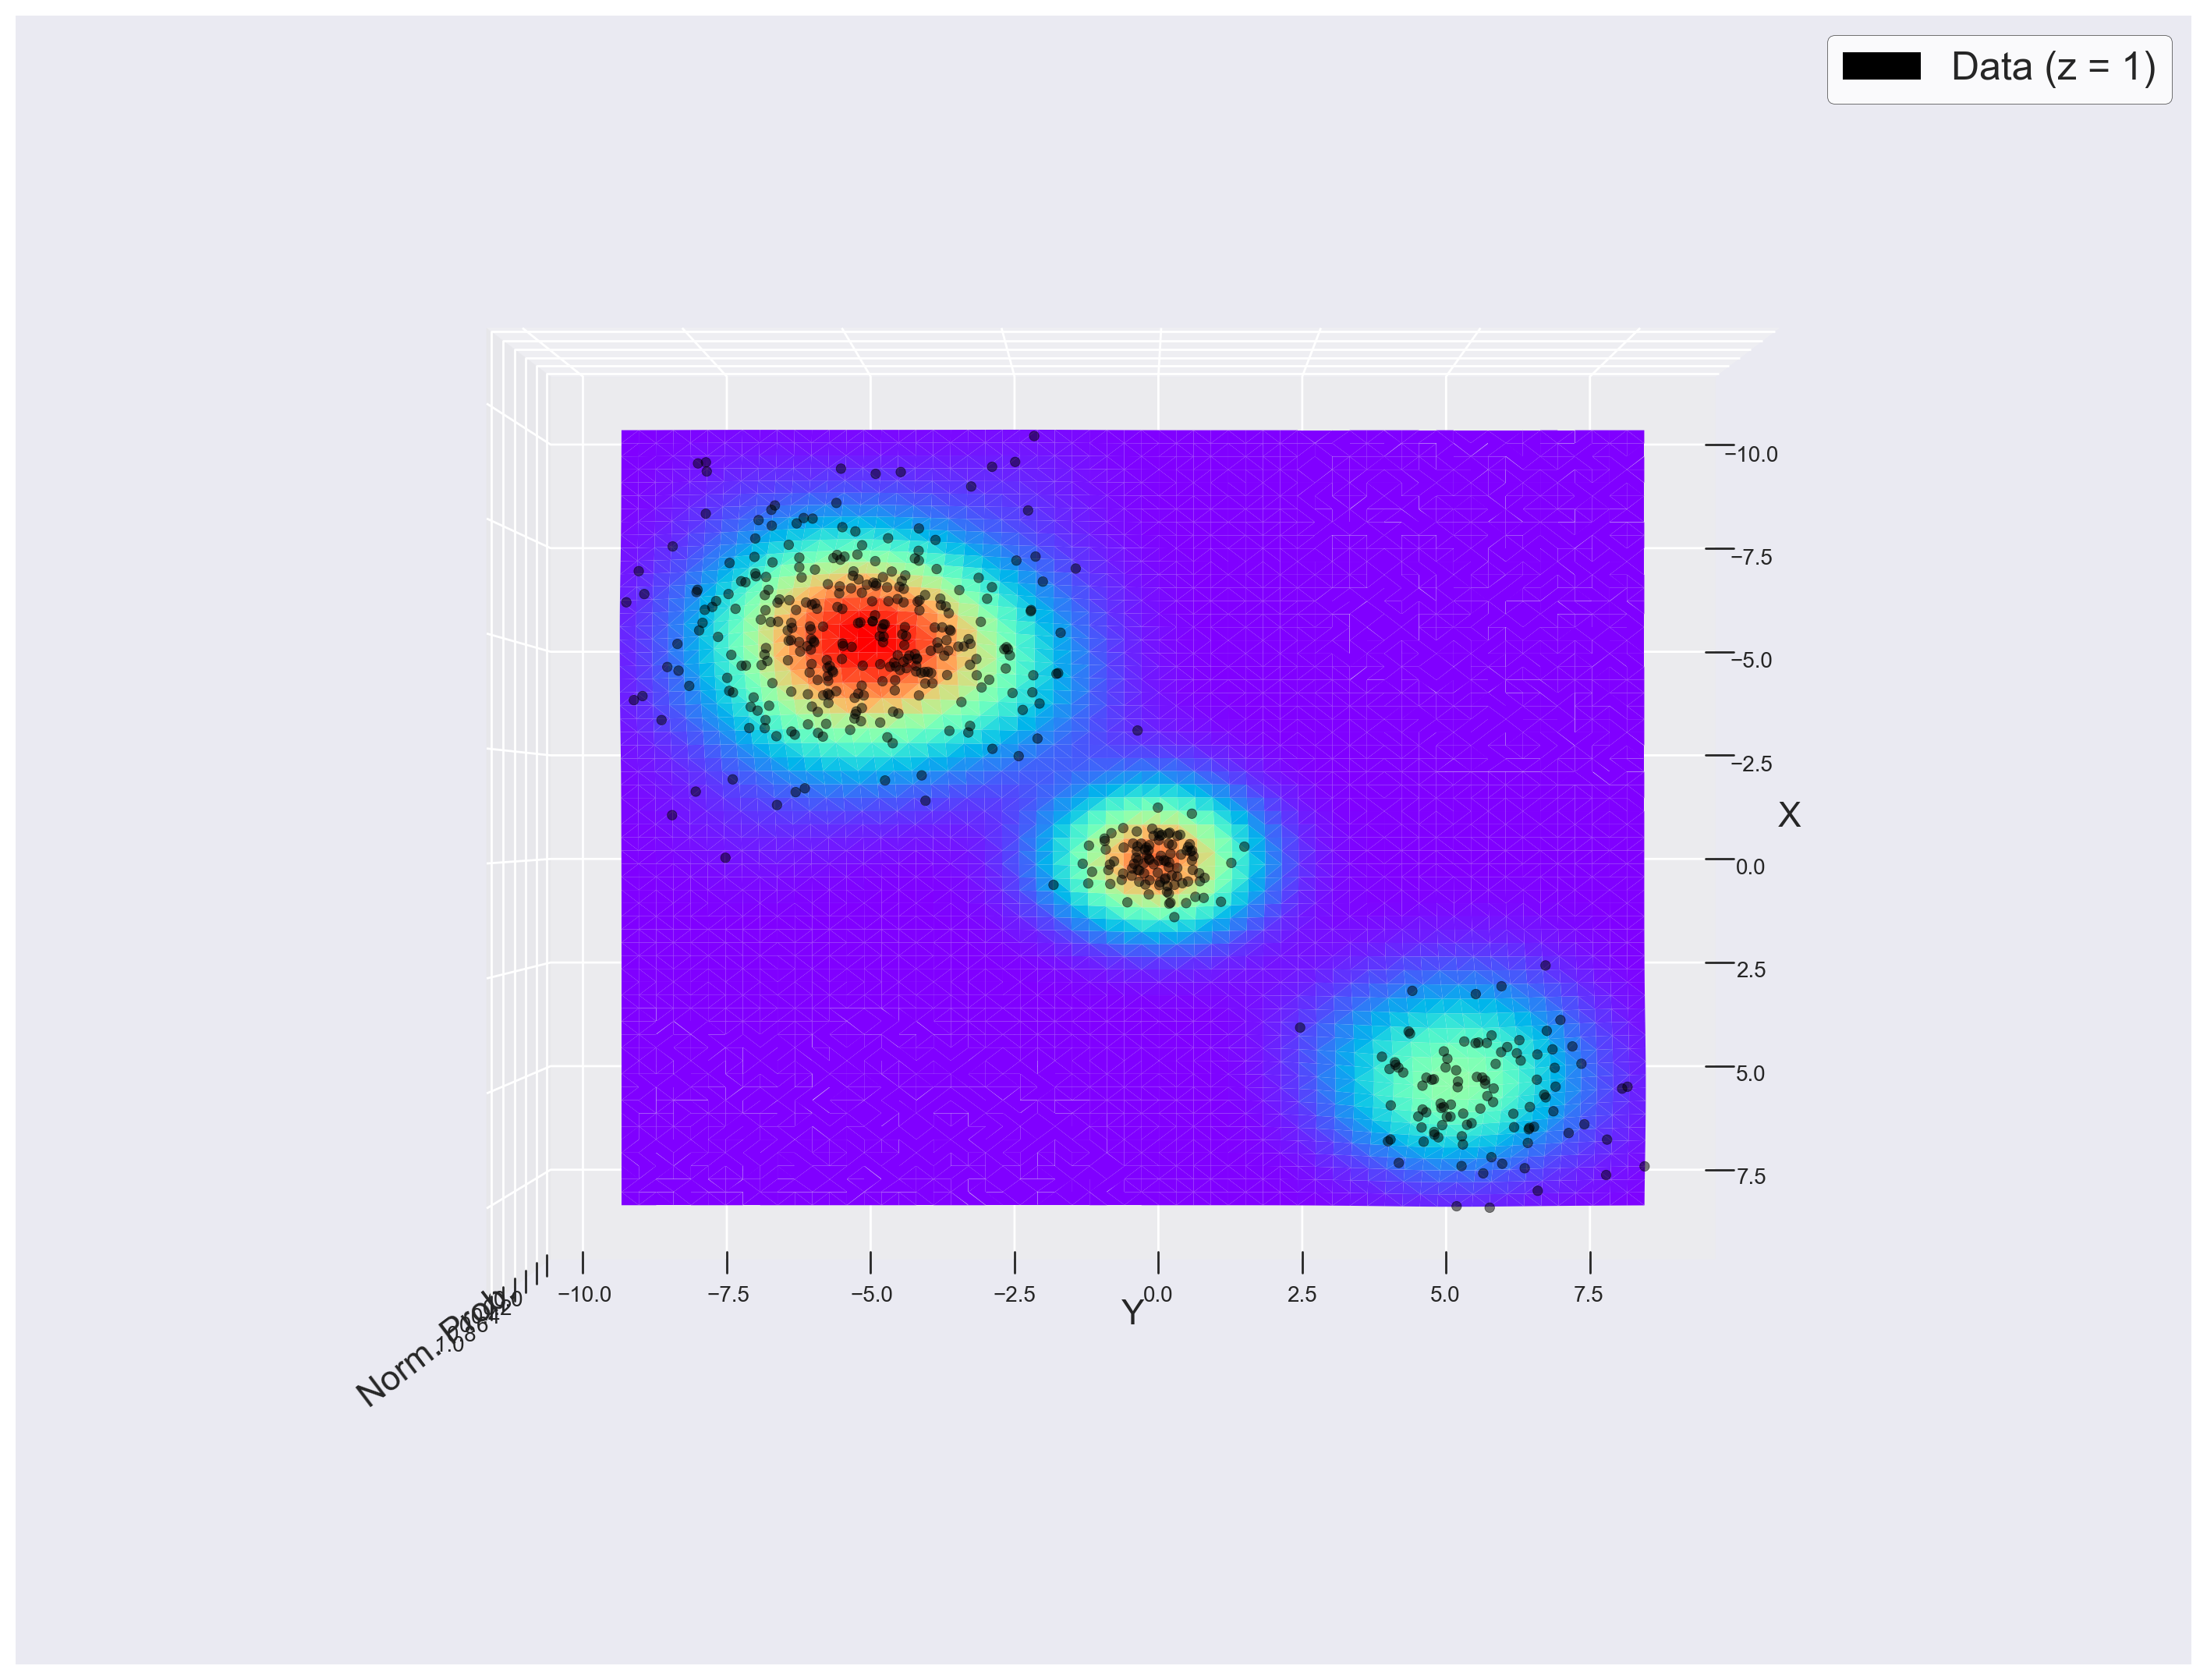

In [39]:
ax = kde2.make_plot()
ax.view_init(90,0);

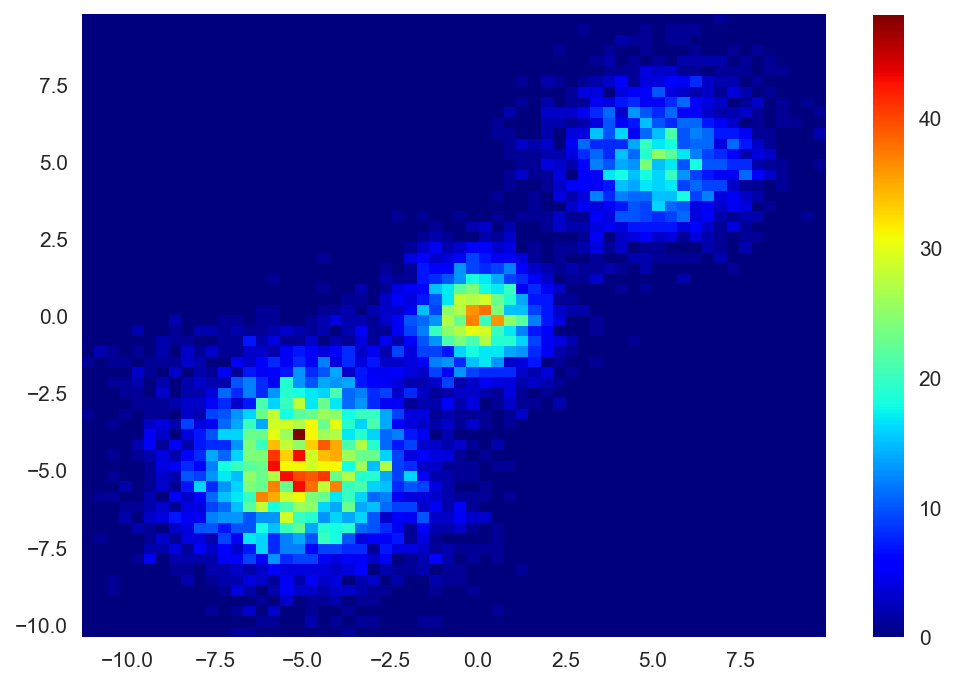

In [40]:
samps = kde2.sample(num_samples=10000, random_state=42)
plt.figure(dpi=150)
plt.hist2d(samps[:,0],samps[:,1], cmap=plt.cm.jet, bins=60);
plt.colorbar()
plt.grid(False)

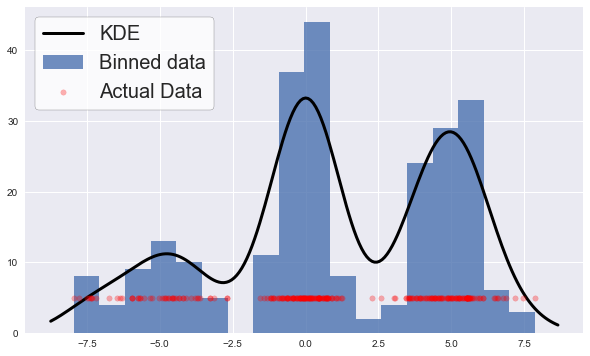

In [41]:
X = np.hstack((np.random.normal(0,0.75,100), np.random.normal(5,1,100), np.random.normal(-5,1.5,50)))
X.shape

kde = kde_approximator(grid_fineness=200)
kde.fit(X)
kde.make_surface()
kde.make_plot();

In [42]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=400, factor=0.5, random_state=0, noise=0.05)

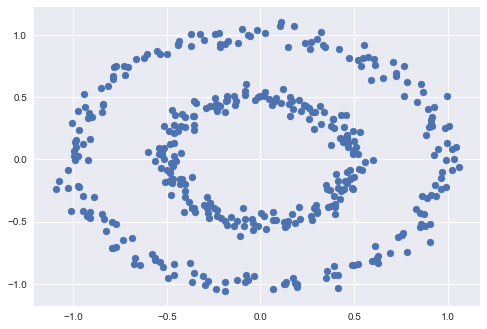

In [43]:
plt.scatter(X[:,0],X[:,1]);

In [44]:
kde2 = kde_approximator(grid_fineness=60, bandwidth=0.1)
kde2.fit(X)
kde2.make_surface()

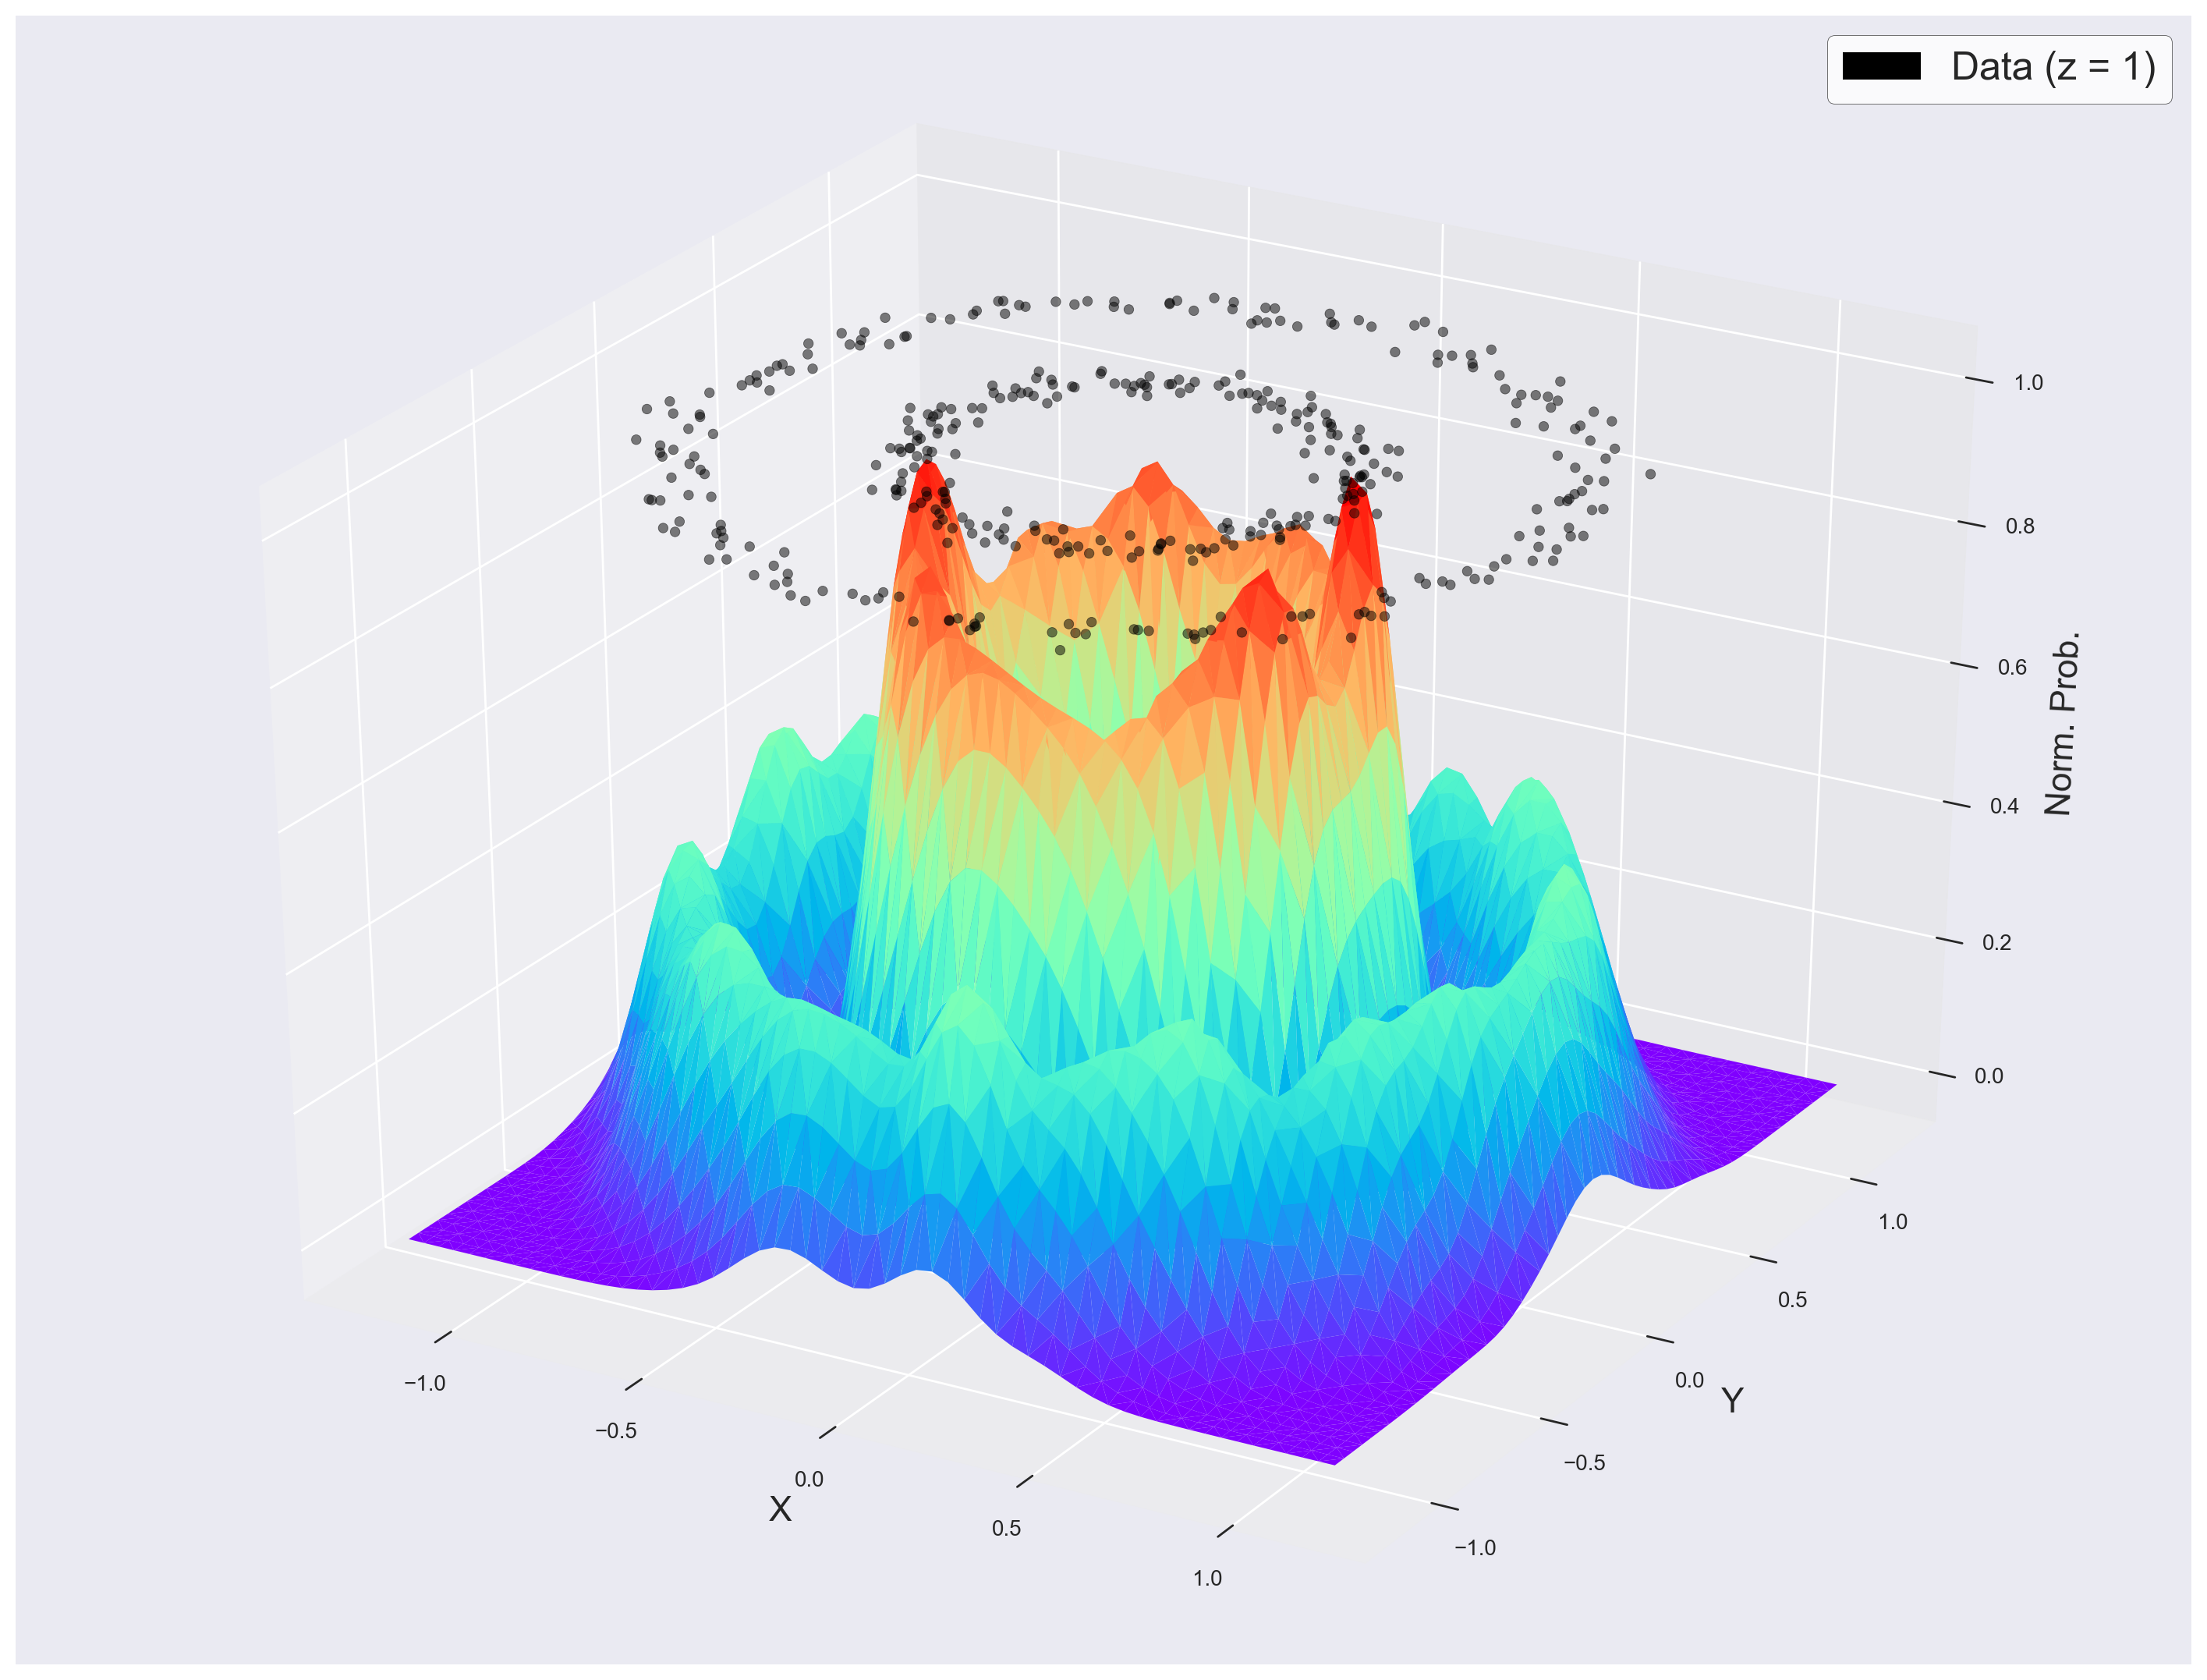

In [45]:
ax = kde2.make_plot();
#ax.view_init(90,90)

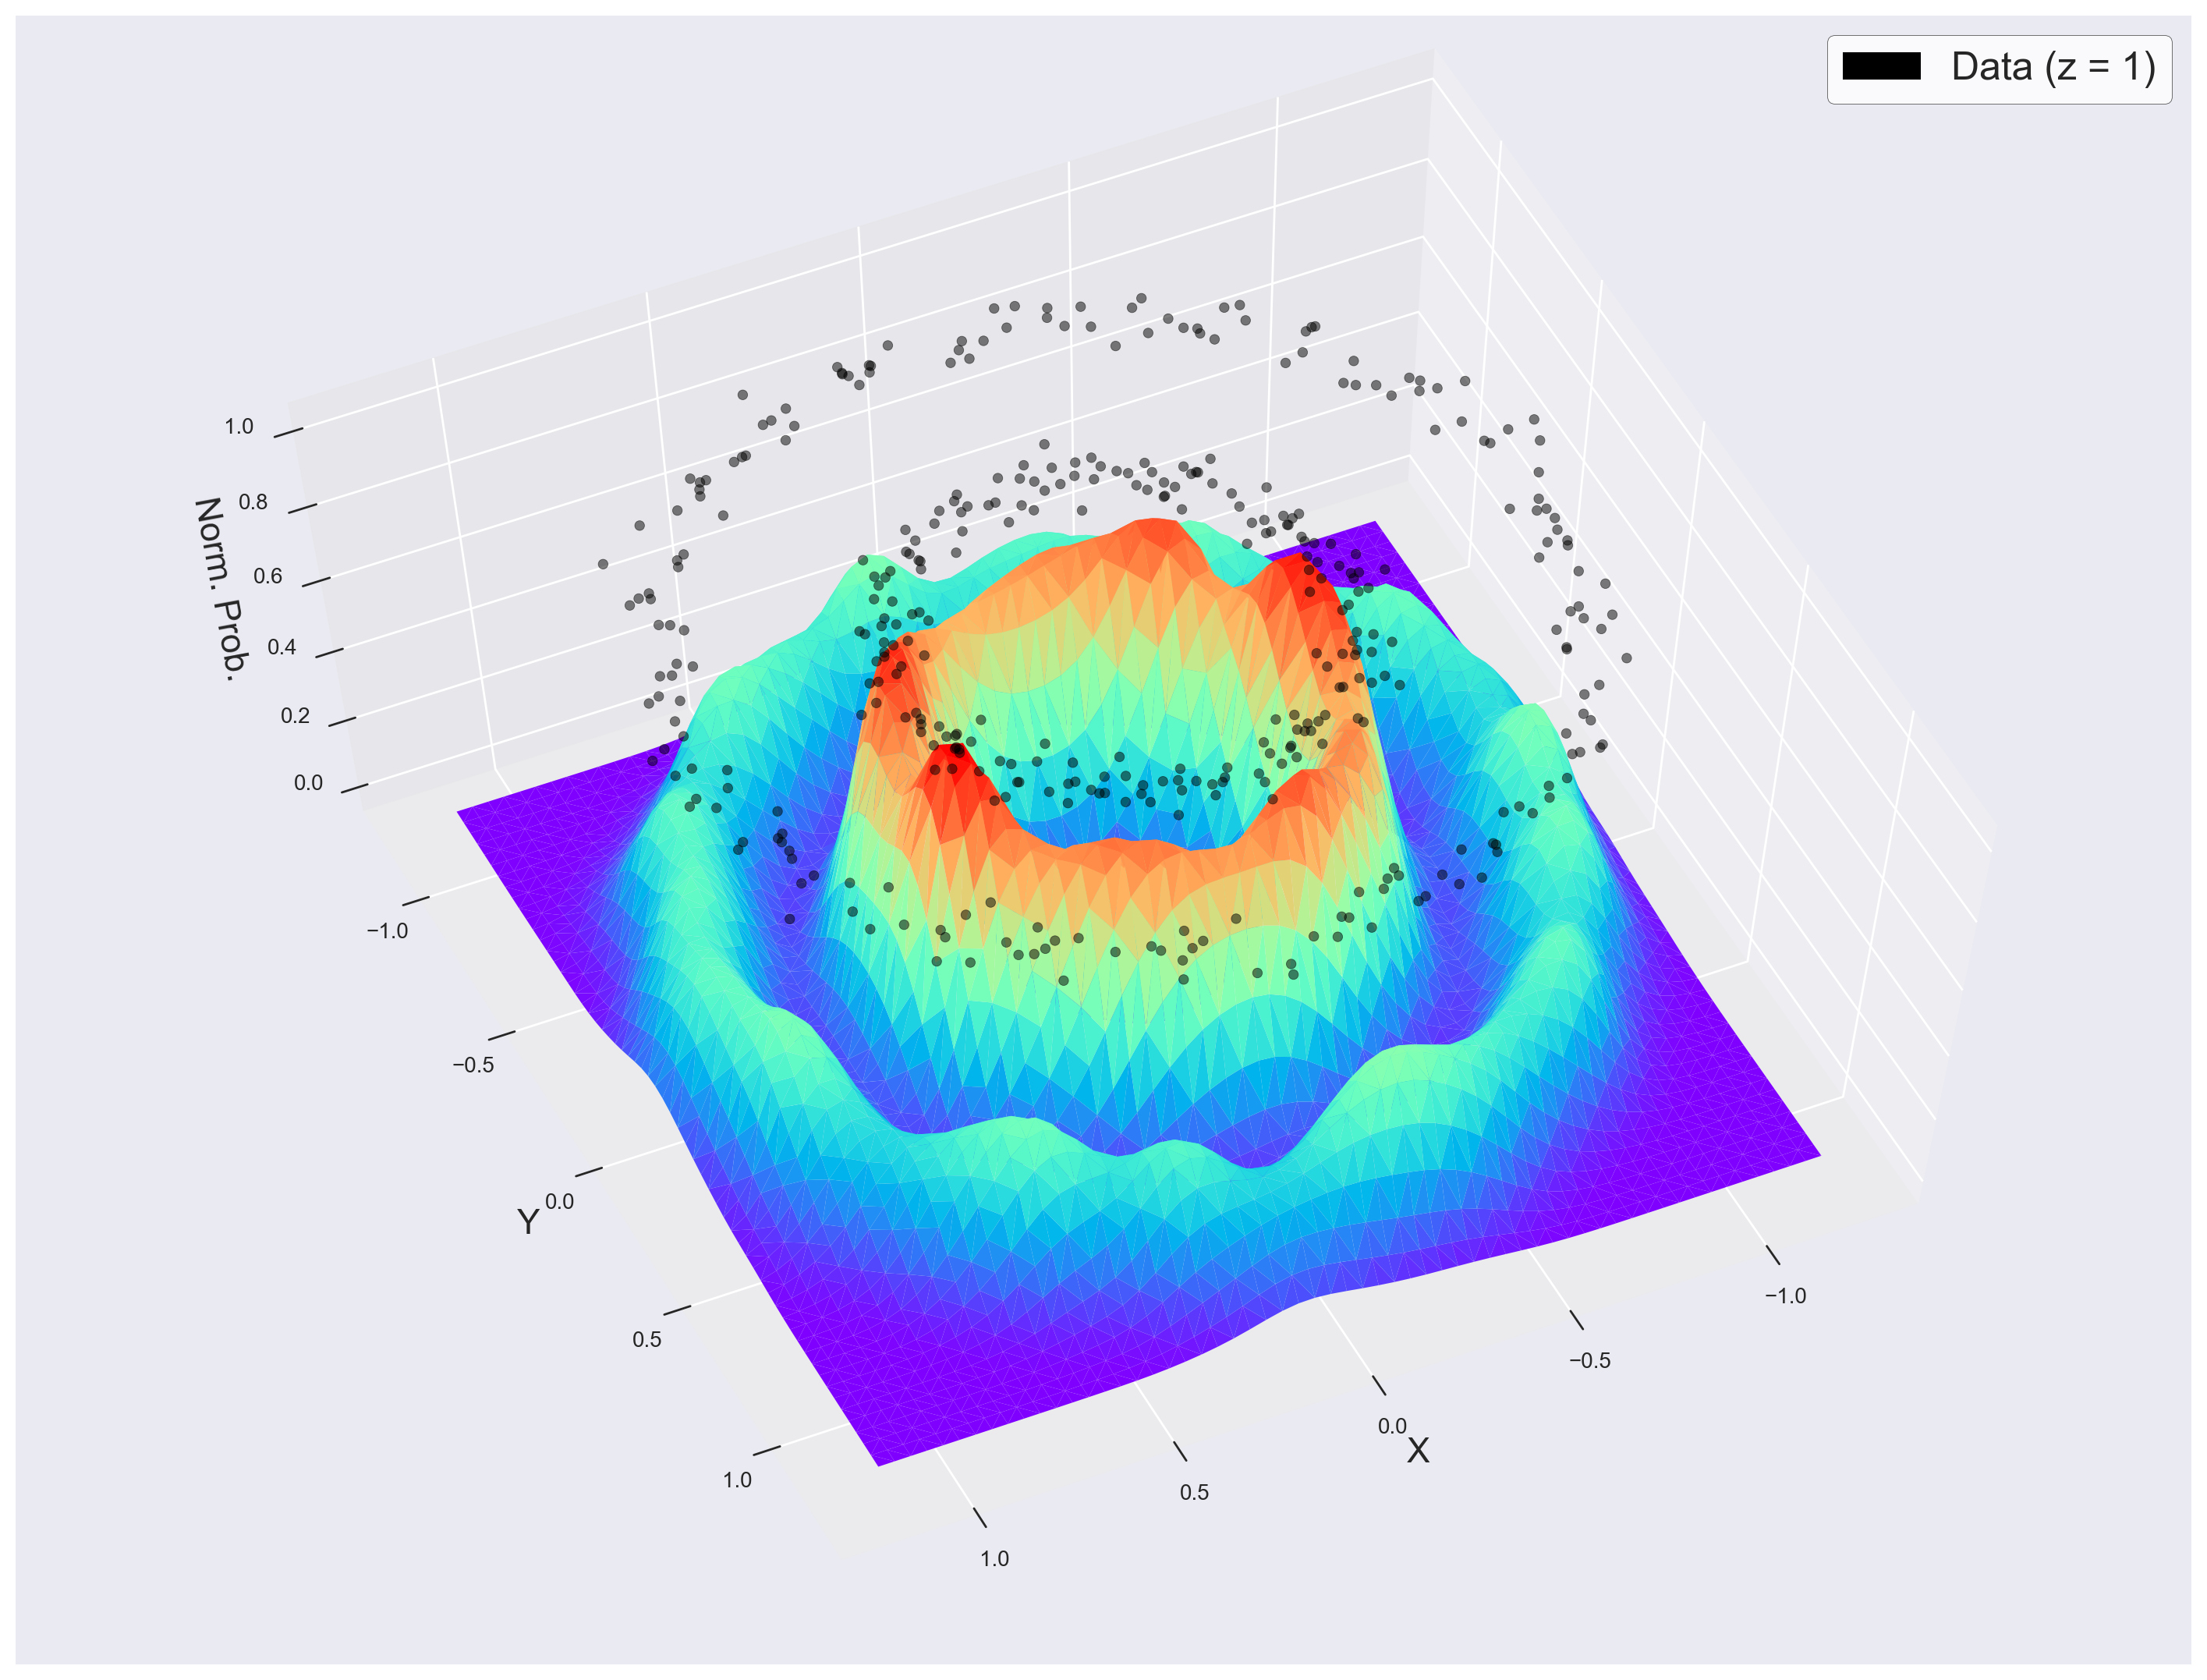

In [46]:
ax = kde2.make_plot();
ax.view_init(65,65)

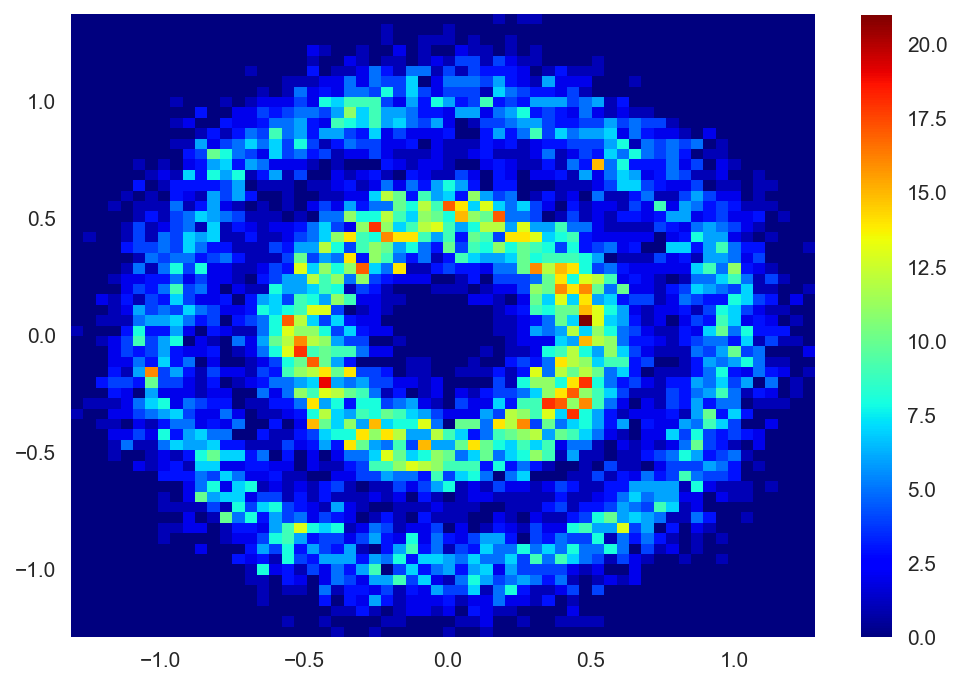

In [47]:
samps = kde2.sample(num_samples=10000, random_state=42)
plt.figure(dpi=150)
plt.hist2d(samps[:,0],samps[:,1], cmap=plt.cm.jet, bins=60);
plt.colorbar()
plt.grid(False)

# And with the uniform distribution!

In [51]:
X = np.vstack((np.random.normal(0,0.5,(100,2)), np.random.normal(5,1,(100,2)), np.random.normal(-5,1.5,(300,2))))
X.shape

(500, 2)

In [52]:
kde2 = kde_approximator(kernel='uniform', grid_fineness=60, bandwidth=1)
kde2.fit(X)
kde2.make_surface()

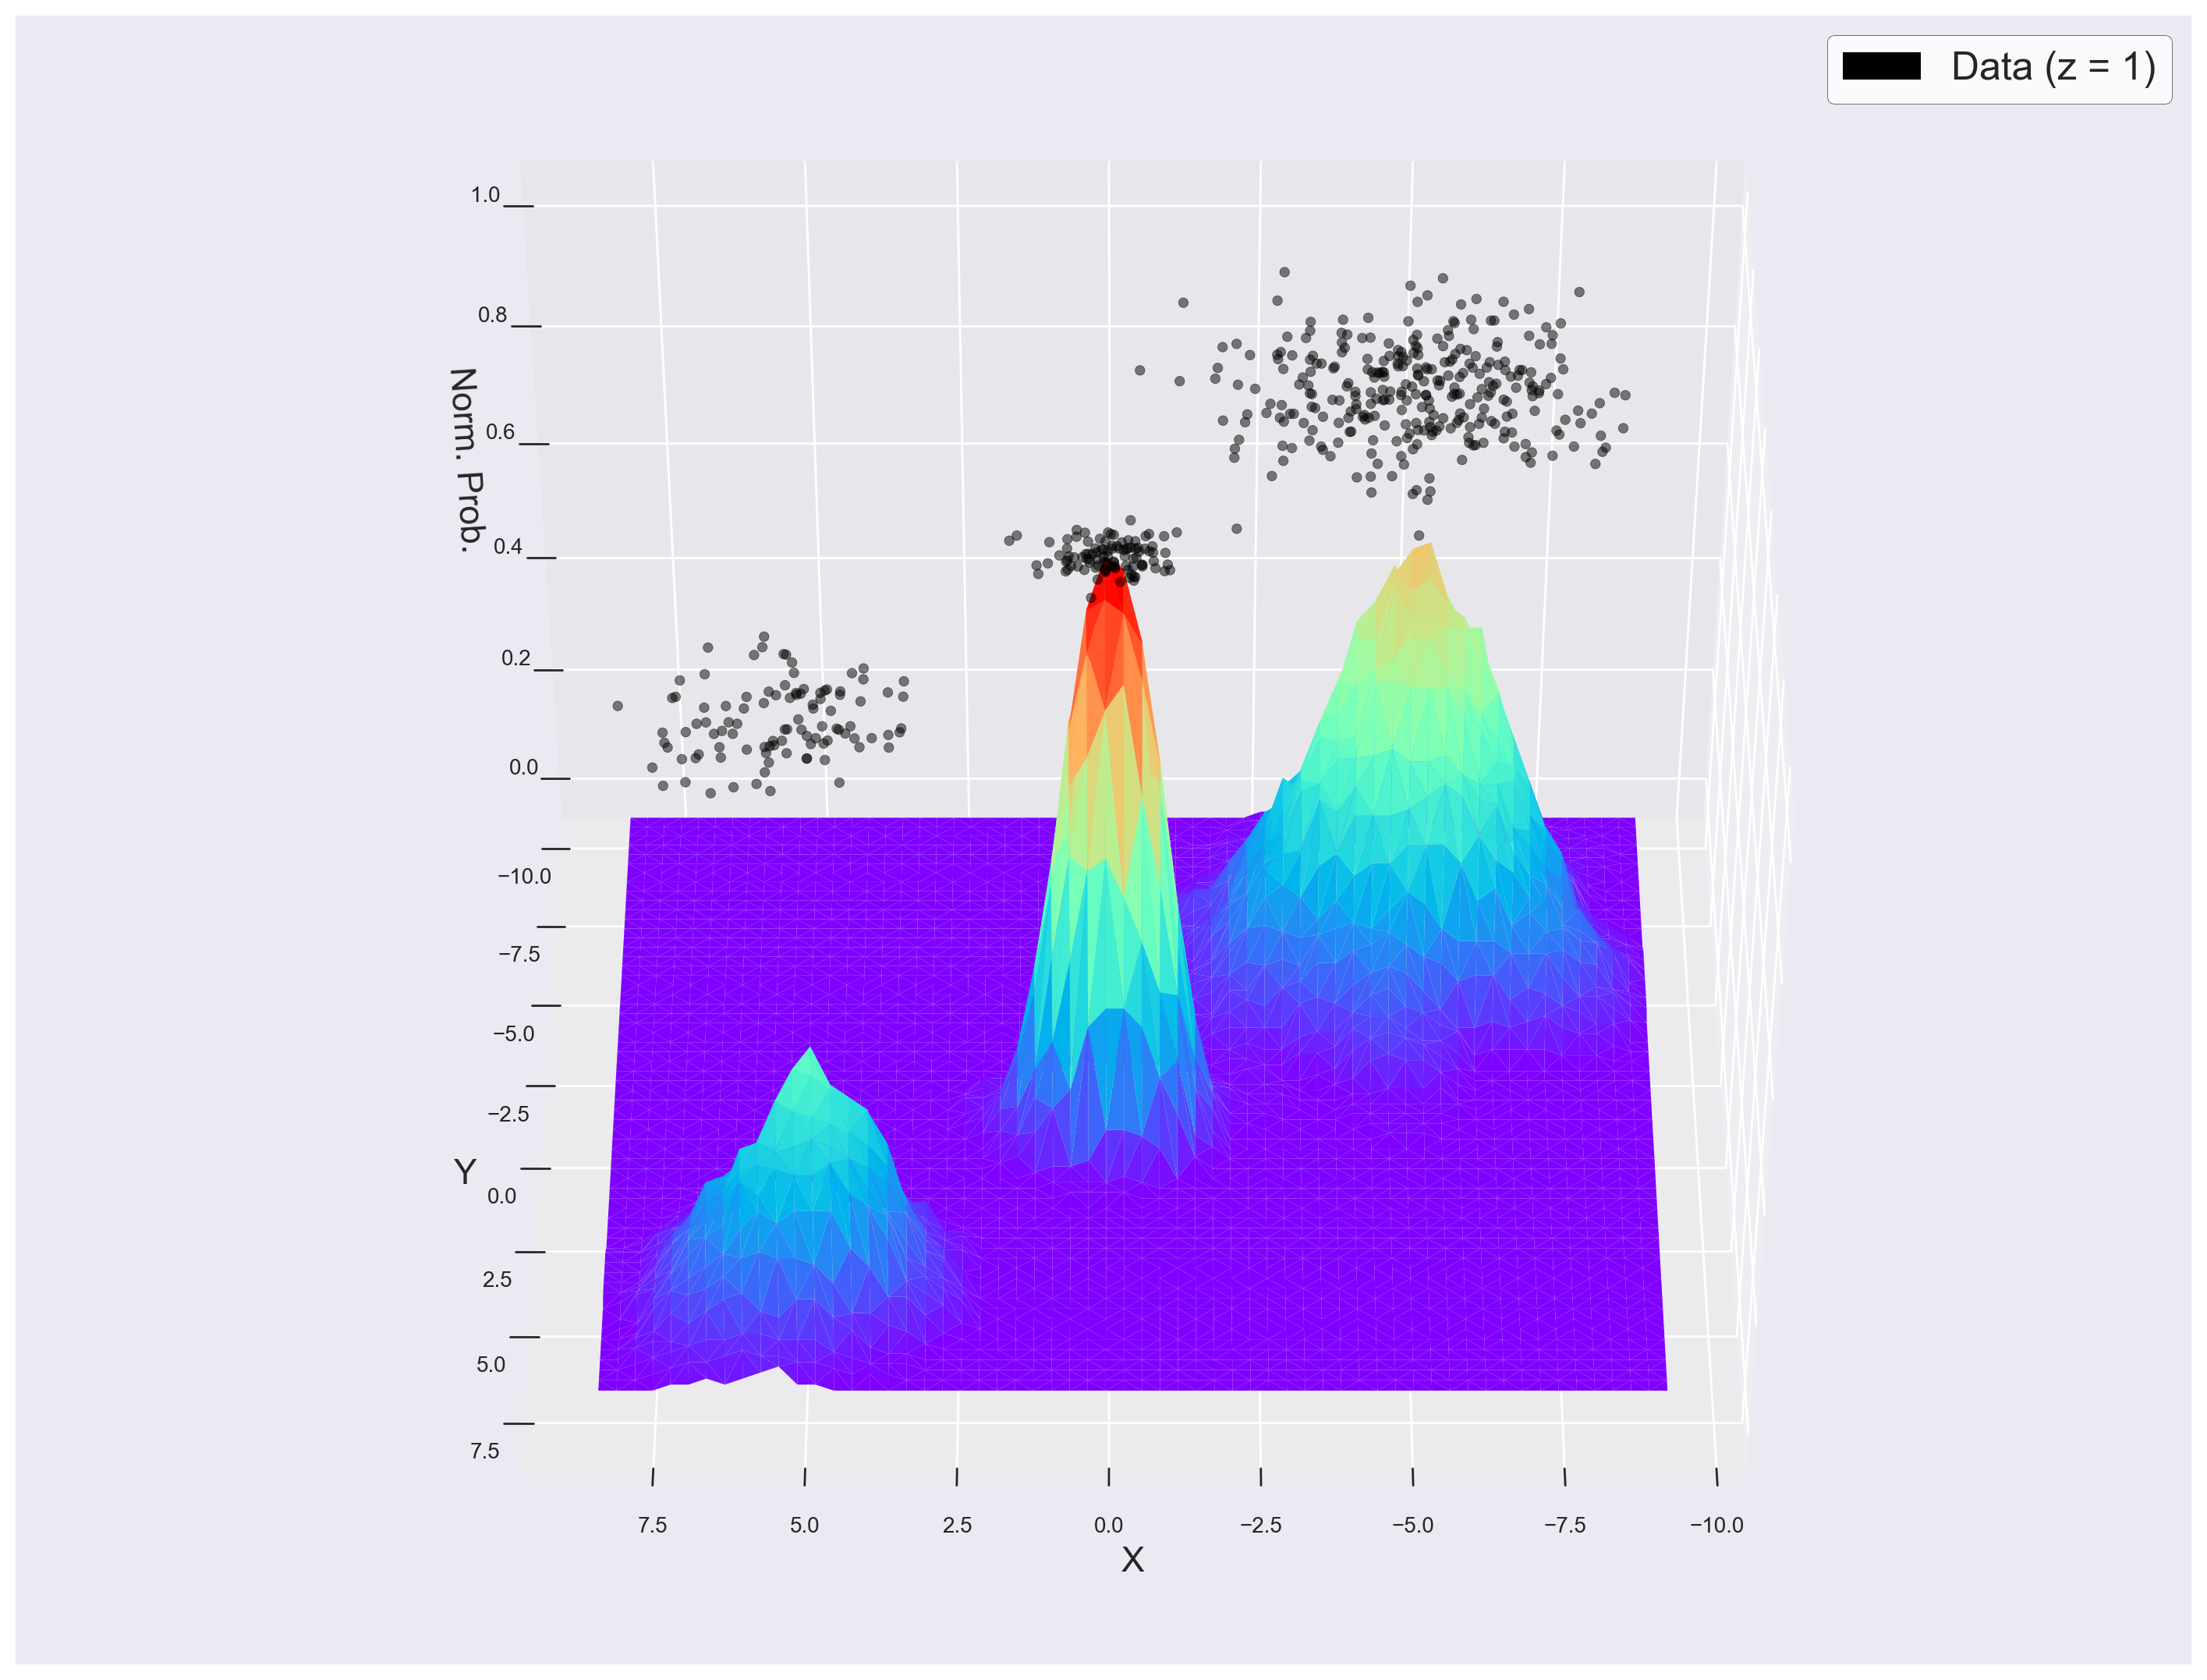

In [53]:
ax = kde2.make_plot()
ax.view_init(45,90);

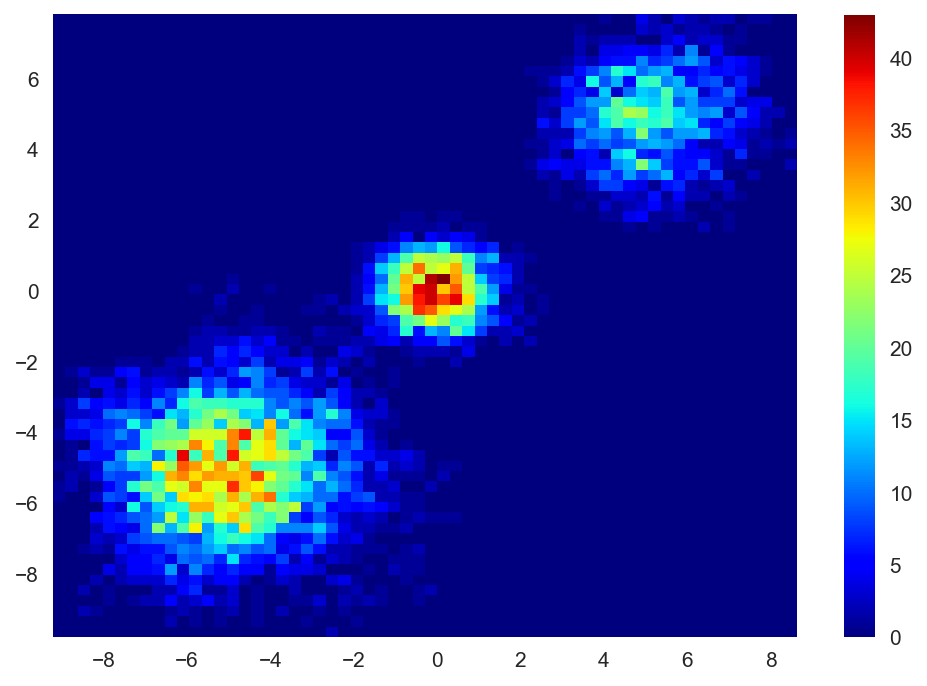

In [54]:
samps = kde2.sample(num_samples=10000, random_state=42)
plt.figure(dpi=150)
plt.hist2d(samps[:,0],samps[:,1], cmap=plt.cm.jet, bins=60);
plt.colorbar()
plt.grid(False)